#An Anatomy of Key Tricks in [word2vec project](https://code.google.com/p/word2vec/) with examples

The python implementation is mainly for educational purpose, as I found myself understand the original code quicker by trying them in an interactive env.

Its implementation is by no means optimal and thus you should not expect its running performance would be comparable to the C version.

Some implementations have been simplified during the translation to better illustrate the idea.

Those are purely ***my personal*** understanding of the code.

In [8]:
import numpy as np
from collections import Counter
import mmap
import re
import networkx as nx
import math

## Precomputed Exponetial Table
- It is a table that pre-calculates exponetials of [logistic function](http://en.wikipedia.org/wiki/Logistic_regression)
$$F(t) = {1\over1 + e^{-t}}$$
- For speeded-up access during the runtime
- The values in the exponetial table are later used as *objective function*

In [3]:
MAX_EXP = 6
EXP_TABLE_SIZE = 1000
EXP_TABLE = np.arange(start = 0, stop = EXP_TABLE_SIZE, 
                      step = 1, dtype = np.float64)
## Exponentials of [-MAX_EXP, MAX_EXP]
EXP_TABLE = np.exp((EXP_TABLE / EXP_TABLE_SIZE * 2 - 1) * MAX_EXP)
## Logitstic Regression of [-MAX_EXP, MAX_EXP]
EXP_TABLE = EXP_TABLE / (EXP_TABLE + 1.)
## SO to use the EXP_TABLE, the value f must be in range [-MAX_EXP, MAX_EXP]
## and first transform the f value to range [0, EXP_TABLE-1]
## and then get the value from the table, e.g., to get logistic function value of f
f = [-6., -3., 0, 3., 6.]
## (f+MAX_EXP) / (MAX_EXP/2) transforms f to [0, 1]
index4exptable = lambda f: int((f+MAX_EXP) * (EXP_TABLE_SIZE/MAX_EXP/2))
f_index = map(index4exptable, f)
logistic_f = EXP_TABLE[f_index]
print f
print f_index
print logistic_f ## values in [0, 1] for logistic regression

[-6.0, -3.0, 0, 3.0, 6.0]
[0, 249, 498, 747, 996]
[ 0.00247262  0.04688669  0.49400029  0.95092101  0.99740611]


## Hashed Vocabulary
- In the C implementation, the vocab is a combination of `hashed vocabulary` and `Huffman tree`.
- A hashed vocab is a vocab and a hash of its elements' index. The elements in vocab is a vocab_word structure (simulated as a dict here) including fields `frequency` (frequency of word), `word` (string repr of word), `path` (point in c-version, all parent nodes of word in Huffman tree), `code` (binary repr of word in Huffman tree)
- The hashing is for fast searching of whether a word is in the vocab
- The vocab_words are sorted by their `count` in the vocab
- The hashed vocab and the tree are built from a train file (a list of words)
- The implementation below ignore the </s> tag as used in the original version, for simplicity
- a very good [illustration](http://upload.wikimedia.org/wikipedia/commons/a/ac/Huffman_huff_demo.gif) of constructing Huffman tree can be found here

In [4]:
class HashedVocab(object):
    HASH_SIZE = 30000000 ## max hash size
    ## count threshold for a word to be in the vocab - ignore infrequent word
    MIN_COUNT = 5 
    @staticmethod
    def file2ws(fpath):
        """
        file to wordstream: lazily read words from a file as an iterator
        """
        with open(fpath) as fin:
            word_pattern = re.compile(r'(.*?)\s')
            mf = mmap.mmap(fin.fileno(), 0, access = mmap.ACCESS_READ)
            for match in word_pattern.finditer(mf):
                word = match.group(1)
                if word: yield word
    def __init__(self):
        ## vocab stores vocab_word dict
        self.vocab = []
        ## vocab_hash stores the index of vocab_word in vocab
        self.vocab_hash = np.empty(HashedVocab.HASH_SIZE, dtype = np.int64)
        self.vocab_hash.fill(-1)
        ## house-keeping - total number of word occurences in training set
        ## it will be used as an estimate of training size later, which 
        ## affect the adjustment of learning rate of the deep structure
        self.n_train_words = 0
    def fit(self, word_stream):
        """
        build hashed_vocab and Huffman tree from word stream
        the word_stream is usually from reading a word file, e.g., using file2ws
        """
        ## word counter
        wc = Counter(word_stream)
        ## total occurances of training words
        self.n_train_words = sum(wc.values())
        ## Sort the words by their counts, filter out infrequent words,
        ## construct vocab_word (a dict) and put them in self.vocab
        self.vocab = map(lambda x: dict(zip(['word', 'count'], x)),
                         filter(lambda x: x[1] > HashedVocab.MIN_COUNT, 
                                wc.most_common(len(wc))))
        ## if vocab is already too big for hash, either (1) ignoring more infrequent
        ## words (as implemented in C by ReduceVocab), (2) making hash size bigger
        ## here we simply raise an exception for simplicity
        if len(self.vocab) > HashedVocab.HASH_SIZE * 0.7:
            raise RuntimeError('vocab size too large for hash, increase MIN_COUNT or HASH_SIZE')
        self.build_hash()
        self.build_huffman_tree()
        return self
    def index_of(self, word):
        """
        Get the index of word in vocab by using hash,
        return -1 if it is NOT there
        """
        word_hash = self.get_word_hash(word)
        while True:
            word_index = self.vocab_hash[word_hash]
            if word_index == -1:
                return -1
            elif word == self.vocab[word_index]['word']:
                return word_index
            else:
                word_hash = (word_hash + 1) % HashedVocab.HASH_SIZE
    def __getitem__(self, word_index):
        """
        get vocab_word in vocab by its index
        """
        return self.vocab[word_index]
    def __len__(self):
        return len(self.vocab)
    def __iter__(self):
        return iter(self.vocab)
    
    
    def build_hash(self):
        self.vocab_hash = np.empty(HashedVocab.HASH_SIZE, dtype = np.int64)
        self.vocab_hash.fill(-1)
        for word_index, vocab_word in enumerate(self.vocab):
            word = vocab_word['word']
            word_hash = self.get_word_hash(word)
            self.add_to_hash(word_hash, word_index)
        return self
    def get_word_hash(self, word):
        word_hash = sum([ord(c)*(257**i) 
                     for i, c in zip(range(len(word))[::-1], word)])
        word_hash %= HashedVocab.HASH_SIZE
        return word_hash
    def add_to_hash(self, word_hash, word_index):
        while self.vocab_hash[word_hash] != -1:
            word_hash = (word_hash + 1) % HashedVocab.HASH_SIZE
        self.vocab_hash[word_hash] = word_index
        return self
    def build_huffman_tree(self):
        """Build the Huffman tree representation for word based on their freq.
        The vocab_word structure in self.vocab is a dict {word, count, path, code}
        where vocab_word['code'] is the Huffman coding of word, and
        vocab_word['path'] will be the path from root to leaf
        """
        ## for a full binary tree with n leaves, n-1 internal nodes will be needed
        ## for the 2*n-1 long data array (e.g. count and binary), the first n will be
        ## for the leaf nodes, and the last n-1 will be for the internal nodes
        vocab_size = len(self)
        ## workhorse structure for tree construction
        ## count - the count of words (leaves) and internal nodes (sum of leave counts)
        count = np.empty(vocab_size * 2 - 1, dtype = np.int64)
        count.fill(1e15)
        count[:vocab_size] = [vw['count'] for vw in self.vocab]
        ## binary - boolean repr for leaves and internal nodes
        binary = np.zeros(vocab_size*2-1, dtype=np.int64)
        ## parent_node - storing the path for each node
        parent_node = np.empty(vocab_size*2-1, dtype = np.int64)
        ## construct the tree 
        ## DESCRIPTION: iteratively group the two ungrouped nodes (leaf or internal) that 
        ## have the smallest counts
        ## Since the vocab is sorted in decreasing counts order (first half ) and 
        ## the newly created internal nodes (second half) will be the order of 
        ## increasing counts (the algorithm invariant), so we only need to check
        ## the two nodes in the middle of array to look for candidates, that is the role
        ## of min1i and min2i
        ## start searching for min1i and min2i from the middle of array
        pos1, pos2 = vocab_size - 1, vocab_size
        ## construct the vocab_size -1 internal nodes
        for a in xrange(vocab_size-1):
            ## min1i
            if pos1 >= 0:
                # min1i = pos1
                if count[pos1] < count[pos2]:
                    min1i, pos1 = pos1, pos1-1
                # min1i = pos2
                else: 
                    min1i, pos2 = pos2, pos2+1
            else: ## running out of leaf nodes
                min1i, pos2 = pos2, pos2+1
            ## min2i
            if pos1 >= 0:
                if count[pos1] < count[pos2]:
                    min2i, pos1 = pos1, pos1-1
                else:
                    min2i, pos2 = pos2, pos2+1
            else:
                min2i, pos2 = pos2, pos2+1
            ## count(parent_node) = count(child1) + count(child2)
            count[vocab_size + a] = count[min1i] + count[min2i]
            ## link parent node index
            parent_node[min1i] = vocab_size + a
            parent_node[min2i] = vocab_size + a
            ## binary encoding for min1i is 0 (left), for min2i is 1 (right)
            binary[min2i] = 1
        ## put the built Huffman tree structure in the vocab_word in vocab
        ## for each leaf node
        for a in xrange(vocab_size):
            ## b starting from leaf, along parent_nodes, to the root
            b = a
            code, path = [], []
            ## traverse along the path to root
            while True:
                code.append(binary[b])
                path.append(b)
                b = parent_node[b]
                ## stop when reaching root
                if b == vocab_size * 2 - 2: break
            ## path (or point) is from root to leaf, with an index offset
            ## -vocab_size
            self.vocab[a]['path'] = [vocab_size - 2] + [p - vocab_size
                                                        for p in path[::-1]]
            self.vocab[a]['code'] = code[::-1]
    def inspect_vocab_tree(self):
        """Draw the built Huffman binary tree for the vocab
        """
        g = nx.DiGraph()
        vocab_size = len(self)
        edges = set()
        for vw in self.vocab:
            tree_path = [i + vocab_size for i in vw['path']]
            tree_path = [i if i >= vocab_size
                         else "%s(%d)" % (self.vocab[i]['word'], self.vocab[i]['count'])
                         for i in tree_path]
            edges.update(zip(tree_path[:-1], tree_path[1:]))
        g.add_edges_from(edges)
        pos = nx.graphviz_layout(g, prog = 'dot')
        nx.draw(g, pos, with_labels = True, arrows = True)
        return g

In [36]:
## examples of buiding the hashed_vocab and its associated Huffman tree
## simple.txt is the first 50K words from original text8
hashed_vocab = HashedVocab()
hashed_vocab.fit(HashedVocab.file2ws('data/first50k.txt'))
print 'totally %i words were used to build vocab' % hashed_vocab.n_train_words
print '%i of them go into the vocab' % len(hashed_vocab)

totally 50000 words were used to build vocab
1179 of them go into the vocab


Populating the interactive namespace from numpy and matplotlib


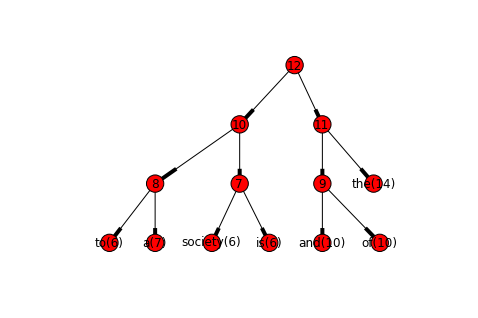

In [37]:
## simple example to illustrate the built Huffman tree
%pylab inline
hashed_vocab = HashedVocab().fit(HashedVocab.file2ws('data/first300.txt'))
hashed_vocab.inspect_vocab_tree()

## Unigram Table
- Unigram table is used for word sampling based on their frequencies. 
- Unigram table is built on word frequencies in the hashed_vocab.
- Here the sampling probability of a unigram is proportional to the its frequency to a powe of 0.75
- The advantage behind using the power-law sampling and the number 0.75 is NOT really clear to me. See [my question](http://metaoptimize.com/qa/questions/13996/how-to-sample-words-by-unigram-model)
- To use the sampling table, use a uniform random int as the index to the table, the word (index) sampled by the table follow a power law distribution based on their frequency estimate

In [5]:
class UnigramTable(object):
    TABLE_SIZE = int(1e8)
    POWER = 0.75
    def __init__(self, hashed_vocab):
        self.table = np.empty(UnigramTable.TABLE_SIZE, np.int64)
        vocab = hashed_vocab
        vocab_size = len(hashed_vocab)
        ## normalization factor of all word's frequency's power
        train_words_pow = sum(math.pow(vw['count'], UnigramTable.POWER)
                              for vw in vocab)
        ## doing the sampling in the table
        ## the sampling probability of a unigram is proportional to its
        ## frequency to a power of POWER (=0.75)
        
        ## i marks the index of current word in vocab
        ## d1 marks the accumulative power-law probability up to the current word
        ## a / TABLE_SIZE marks the sampling proability up to the current word
        i = 0
        d1 = math.pow(vocab[i]['count'], UnigramTable.POWER) / train_words_pow
        for a in xrange(self.TABLE_SIZE):
            self.table[a] = i
            ## compare accumulative sampling prob with power-law accumulative prob
            ## move to the sampling of next word if they start not matching
            if a * 1. / UnigramTable.TABLE_SIZE > d1:
                i += 1
                d1 += math.pow(vocab[i]['count'], UnigramTable.POWER) / train_words_pow
            ## put the rest as sampling of the last word (round-off)
            if i >= vocab_size:
                i = vocab_size - 1
    def __getitem__(self, index):
        return self.table[index]

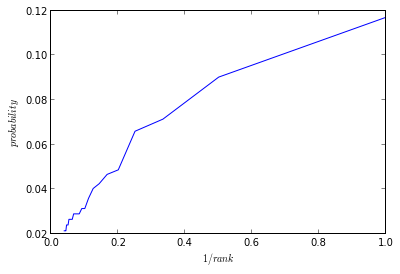

In [7]:
## check how satisfying the sampling strategy is to the Zipf's law
## http://mathworld.wolfram.com/ZipfsLaw.html
hashed_vocab = HashedVocab().fit(HashedVocab.file2ws('data/first1k.txt'))
unigram_table = UnigramTable(hashed_vocab)
sampling_probs = [sum(unigram_table.table == i) / 1e8 for i in xrange(len(hashed_vocab))]
plot(1./np.arange(1, len(hashed_vocab)+1), sampling_probs)
xlabel('$1/rank$')
ylabel('$probability$')

## Neural Network for Feature Learning
- In terms of neural network architecture, it could be `cbow` (continous bag of words) or `skip_gram`
- In terms of learning method, it could be `hs` (hierarchical softmax) or `negative` (negative sampling) or both
- see the reference paper in the original code base for pros and cons of different combinations

### 1. Continous Bag of Words Model 

The main data structures of CBOW (and for Skip_gram) are `syn0`, `syn1` and `syn1neg`. All of them can be viewed as feature reprs of the words in the vocab, but the words are combined in different specific ways. For example, 

- `syn0` are the feature repr of words (also the leaf nodes in the Huffman tree) to be learned, and the words that are fired in `syn0` are a continuous sequence in a sentence (neighbors in semantic matter). 
- `syn1` are the feature repr of internal nodes in the Huffman tree. The words that are fired together are similiar to each other in the way that they are common parents of close words (in terms of similiar frequency) in the Huffman tree.  Parents of word nodes in Huffman tree are analogy to prototypes of clusters formed by words.
- `syn1neg` are also feature repr of words in the vocab, but those words are selected via negative sampling. The words are sampled based on their frequency. 

The basic idea is to **learn** both `syn0` and `syn1`(and/or `syn1neg1). It might be helpful to understand the code in the following way. Again this is my personal understanding of the code, if it is wrong, it has nothing to do with the original project. 

1. The cbow net can be thought of as a two-layer network. The nodes between two layers are **partially** connected. 
2. The first layer (input layer) are syn0 for both hs and negative-sampling.
3. For hs, the second layer consists of the *parent* nodes in the Huffman tree. For a certain word w, there is a group of nodes in layer0 corresponding to the **neighbor words** around w in a sentence; and there is a group of nodes in layer1 corresponding to the **parent nodes** of w in Huffman tree. The connections only exist in the two groups in layer0 and layer1, and the weights of the connections are syn1, which is specific in each parent node in layer1. 
4. Similiarly for negative-sampling, but here the connections between nodes in layer0 and layer1 are actually *randomly sampled* - the nodes in layer1 are selected based on the power-law sampling given in Unigram Table. 
#### ================= Trained with HS ====================
5. The computation happens in two directions. 
6. The forward computation first calculate `neu1` as the sum of the related nodes in layer0 (syn0 vectors). The output `f` is calcualted as the logistic transformation of inner product between `neu1` and `syn1`.
7. Since the nodes that will be turned on in layer1 are parent nodes in Huffman tree, it is like training a multi-classification problem via the network. Here the pesudo targets for the output layer are the binary encoding of the corresponding parent nodes for the certain word. The reason behind this is that the parent nodes (and their encoding for a certain word) are a *sparse* and *deep* representation of the word - it is similiar to a hierarchical clustering with cluster prototypes as the parent nodes.
8. So we have the output `f` and the psuedo target binary encoding of the word, we can calucate the cost function and thus gradient. By making the output and pseudo-target close to each other, we enforce that the feature represented as `syn0` (based on a word's context information in a sentence) can be used to approximate the distribution of the word in terms of the encoding by the Huffman tree. The gradient is calculated as `g` in the code (actually just part of it, the gradient is `g` multiplied by the input vector for a logistic regression training).
9. Both `syn0` and `syn1` are updated according to the gradient, **interleavingly and iteratively**. That is, `syn1` are updated based on gradient, and all the connected `syn0` (neighbors in a sentence); and `syn0` are updated based on gradient, and all the connected `syn1` (parent nodes of the word in Huffman tree).
#### ================= Trained with Negative Sampling ====================
10. The forward calculation and backward updating are generally the same as in HS. 
11. The main differences are that the connected nodes in layer1 (represented by `syn1neg`) are from a sampling of the whole vocabulary, instead of from the Huffman tree.
12. Accordingly, the pseduo target is are zero-one (similiar to sumvector of a traditioanl bag of words repr.). This essentially enforces that the `syn0` repr will be very close to itself and 'orthgonal' to other words - kind of like a autoencoder flavor. 
13. Compared to the encoding by Huffman tree, this 'bag-of-words' repr is not *deep*, and so it generally needs more instances in the training data.

In [6]:
class CBOW(object):
    REAL_TYPE = np.float64
    def __init__(self, hashed_vocab, unigram_table,
                 layer1_size, learn_hs, learn_negative):
        """
        hashed_vocab: the vocab to build on
        layer1_size: the size of layer1 of the net, effectively defines the dim of feature space
        learn_hs: use hierarchical softmax learning
        learn_negative: use negative sampling learning
        """
        self.vocab = hashed_vocab
        self.table = unigram_table
        self.layer1_size = layer1_size
        self.learn_hs = learn_hs
        self.learn_negative = learn_negative
        
        ## initial value for learning rate, will decrease along learning
        self.starting_alpha = 0.025
        ## a sentence is a bulk of words from train file
        self.sentence_len = 1000
        ## downsampling rate to select words into a sentence
        self.sampling = 1e-4
        ## window defines the neighborhood of a word in the sentence for hs learning
        self.window = 5
        ## negative defines the neighborhood of a word for negative learning
        self.negative = 5
        
        ## network weights
        ## syn0 - feature representations of words (leaf nodes) in Huffman tree
        ## shape = vocab_size x layer1_size
        self.syn0 = None 
        ## syn1 - feature representations of internal nodes (non-leaf) in Huffman tree
        ## shape = vocab_size x layer1_size
        self.syn1 = None ## hidden layer for hs learning
        ## syn1neg - feature representations of negative-sampled words
        ## shape = vocab_size x layer1_size
        self.syn1neg = None ## hidden layer for negative learning
    def init_net(self):
        """
        """
        vocab_size = len(self.vocab)
        self.syn0 = np.random.uniform(low = -.5 / self.layer1_size, 
                                      high = .5 / self.layer1_size,
                                      size = (vocab_size, self.layer1_size)).astype(CBOW.REAL_TYPE)
        if self.learn_hs:
            self.syn1 = np.zeros((vocab_size, self.layer1_size), dtype=CBOW.REAL_TYPE)
        if self.learn_negative:
            self.syn1neg = np.zeros((vocab_size, self.layer1_size), dtype = CBOW.REAL_TYPE)
    def fit(self, train_words):
        """
        train_words: list of training words
        """
        ## initialize net structure
        self.init_net()
        ntotal = len(train_words)
        ## initialize learning parameters
        alpha = self.starting_alpha
        next_random = 0
        
        ## read and process words sentence by sentence
        ## from the train_words 
        nprocessed = 0
        while nprocessed < ntotal:
            ## adjust learning rate based on how many words have
            ## been trained on
            alpha = max(self.starting_alpha * (1-nprocessed/(ntotal+1.)),
                        self.starting_alpha * 0.0001)
            ## refill the sentence
            sentence = []
            while nprocessed < ntotal and len(sentence) < self.sentence_len:
                ## sampling down the infrequent words
                word = train_words[nprocessed]
                word_index = self.vocab.index_of(word)
                nprocessed += 1
                if word_index == -1: continue
                word_count = self.vocab[word_index]['count']
                if self.sampling > 0:
                    ran = ( (math.sqrt(word_count / (self.sampling * ntotal)) + 1) 
                            * (self.sampling * ntotal) / word_count )
                    next_random = next_random * 25214903917 + 11
                    ## down sampling based on word frequency
                    if ran < (next_random & 0xFFFF) / 65536: continue
                sentence.append(word_index)
            ## for each word in the preloaded sentence
            ## pivot is the vocab index of current word to be trained on
            ## ipivot is the index in the current setence
            for ipivot, pivot in enumerate(sentence):
                next_random = next_random * 25214903917 + 11
                ## window-b defines the length of the window
                ## which is the neighborhood size for the current
                ## word in the sentence
                b = next_random % self.window
                ## initialize temp variable
                ## neu1: the sum of neigbhor vectors in the setence
                ## neu1e: the gradient vector wrt syn0
                ## see the explaination above the code
                neu1 = np.zeros(self.layer1_size, dtype = self.REAL_TYPE)
                neu1e = np.zeros(self.layer1_size, dtype = self.REAL_TYPE)
                ## accumulate sum of neighbor words into neu1
                ## neighbors are defined as [ipivot-(window-b), ipivot+(window-b)]
                left = max(0, ipivot - (self.window-b))
                right = min(len(sentence)-1, ipivot+self.window-b)
                ## all neighborhood index should >= 0 (in vocab) as otherwise
                ## it won't go into the sentence in the first place
                neighborhood = [sentence[n] for n in range(left, right+1) 
                                    if sentence[n] >= 0]
                neu1 = np.sum(self.syn0[neighborhood,:], axis = 0)
                ## hierarchical softmax learning
                if self.learn_hs:
                    ## for each output node in layer1 
                    ## which are parent nodes of pivot in Huffman tree
                    ## notice the last element of 'path' is the word itself, 
                    ## so exclude it here 
                    for parent_index, parent_code in zip(self.vocab[pivot]['path'][:-1],
                                                             self.vocab[pivot]['code']):
                        ## F is the logistic transformation of dot product 
                        ## between neu1 and each parent repr in syn1
                        f = np.dot(neu1, self.syn1[parent_index, :])
                        ## output out of range
                        if f <= - MAX_EXP or f >= MAX_EXP:
                            continue
                        ## logistic function transformation
                        else:
                            f = EXP_TABLE[int((f + MAX_EXP) * (EXP_TABLE_SIZE / MAX_EXP / 2))]
                        ## pseduo target is 1 - parent_code
                        g = (1 - parent_code - f) * alpha
                        ## accumulate neu1 to update syn0 later
                        neu1e += g * self.syn1[parent_index]
                        ## update syn1 of current parent
                        self.syn1[parent_index] += g * neu1
                ## negative sampling learning
                ## select one positive and several negative samples
                if self.learn_negative:
                    for d in range(self.negative + 1):
                        ## make sure to select the current word
                        ## as positive sample
                        if d == 0:
                            target = pivot
                            label = 1
                        ## select some 'negative' samples randomly
                        else:
                            next_random = next_random * 25214903917 + 11
                            target = self.table[(next_random >> 16) % self.table.TABLE_SIZE]
                            if (target == pivot): continue ## ignore if it is still positive
                            label = 0
                        ## this time f is dot product of neu1 with 
                        ## syn1neg
                        f = np.dot(neu1, self.syn1neg[target, :])
                        ## pseudo target is label
                        ## NOTE the differece between hs and negative-sampling
                        ## when dealing with f out of [-MAX_EXP, MAX_EXP]
                        if f > MAX_EXP:
                            g = (label - 1) * alpha 
                        elif f < - MAX_EXP:
                            g = (label - 0) * alpha
                        else:
                            g = alpha * (label - 
                                    EXP_TABLE[int((f + MAX_EXP) 
                                        * (EXP_TABLE_SIZE / MAX_EXP / 2))])
                        ## accumulate changes to syn0 to neu1e again
                        neu1e += g * self.syn1neg[target]
                ## update syn0 after hs and/or negative-sampling learning
                self.syn0[neighborhood, :] += neu1e

In [9]:
## test cbow
hashed_vocab = HashedVocab().fit(HashedVocab.file2ws('data/first50k.txt'))
unigram_table = UnigramTable(hashed_vocab)
train_words = list(HashedVocab.file2ws('data/first50k.txt'))

In [10]:
cbow_model = CBOW(hashed_vocab, unigram_table,
                  layer1_size = 50, 
                  learn_hs = True, learn_negative = True)
cbow_model.fit(train_words)

In [29]:
from numpy import linalg
Xnorm = np.apply_along_axis(linalg.norm, 1, cbow_model.syn0)
#X = cbow_model.syn0 / Xnorm[:, np.newaxis]
X = cbow_model.syn0
word = cbow_model.vocab.index_of('one')
word_vec = X[word]
#closest_words = np.dot(X, guess).argsort()[::-1]
closest_words = np.sum((X - word_vec)**2, axis = 1).argsort()
for i in closest_words[:5]:
    print cbow_model.vocab[i]['word']

one
eight
three
four
seven


### 2. Skip_gram Model